This is generic code showing how to calculate a Jensen-Shannon distance from `plotFingerprint` output. These are two DEEP samples that I randomly chose.

"foo.cnts" holds the counts produced by plotFingerprint.

In [35]:
%matplotlib inline
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

f = open("foo.cnts")
chip = np.zeros(20000, dtype=np.int)
input = np.zeros(20000, dtype=np.int)
for line in f:
    if line.startswith("'"):
        continue
    cols = line.strip().split("\t")
    cols = [int(x) for x in cols]
    if cols[0] > 0:
        if cols[0] >= 20000:
            cols[0] = 19999
        chip[cols[0]] += 1
    if cols[1] > 0:
        if cols[1] >= 20000:
            cols[1] = 19999
        input[cols[1]] += 1

def signalAndBinDist(x):
    x = np.array(x)
    (n,) = x.shape
    signalValues = np.array(list(range(n)))
    totalSignal = x * signalValues
    normalizedTotalSignal = np.cumsum(totalSignal) / np.sum(totalSignal)
    binDist = np.cumsum(x)/sum(x)
    interpolater = interpolate.interp1d(binDist, normalizedTotalSignal, fill_value="extrapolate")
    return (binDist, normalizedTotalSignal, interpolater)

chipSignal = signalAndBinDist(chip)
inputSignal = signalAndBinDist(input)
chipSignalInterp = chipSignal[2](inputSignal[0])

`chipSignal` and `inputSignal` are tuples of the CDF of the coverage and genomic coverages. The interpolation makes the coverage bins with 0 counts the same between both samples. I'm not sure how legitimate that is, though presumably in practice cases where this

In [36]:
PMFinput = np.ediff1d(inputSignal[1])
PMFchip = np.ediff1d(chipSignalInterp)

The PMFs still contain zeros, so those need to be excluded when computing the JSD. Since they should now always be at the same spot in both PMFs then this is legitimate. The output is the Jensen-Shannon distance (aka, `sqrt(JS divergence)`). The ChIP here is for H3K4Me3, so this is somewhere in the upper distribution of distances for it (according to the slides).

In [37]:
M = (PMFinput + PMFchip) / 2.0
idx = np.nonzero(M)
JSD = 0.5 * (np.sum(PMFinput[idx] * np.log2(PMFinput[idx]/M[idx]))) + 0.5 * (np.sum(PMFchip[idx] * np.log2(PMFchip[idx]/M[idx])))
np.sqrt(JSD)

0.4308556087266856

Since I was curious, we also get "peaky" data in the input coverage histogram on occasion (though not in the ChIP in this case).

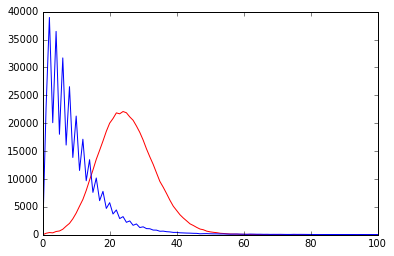

In [39]:
plt.plot(chip, "r", input, "b")
plt.axis([0, 100, 0, 40000])
plt.show()